# Face Detection and Gender Classification
We detect locations of faces using **MTCNN** and then classifies the face after some processing according to its gender using our own **CNN model**

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import os
from mtcnn.mtcnn import MTCNN

2021-07-25 14:20:11.218289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sahil/myfiles/auv/training/assing_1/work/devel/lib:/opt/ros/noetic/lib
2021-07-25 14:20:11.218316: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def relu(x):
    x = (int)(x)
    if x<0:
        return 0
    else:
        return x

## Detecting position of faces
**We have used MTCNN for this**

In [3]:
def detect_faces(image, scaleFactor = 1.1):
    image_copy = image.copy()
    detector = MTCNN()
    faces_rect = detector.detect_faces(image_copy)
    rect = np.zeros([len(faces_rect),4],dtype=int)
    eyes = np.zeros([len(faces_rect),4],dtype=int)
    for i,face in enumerate(faces_rect):
        # print(face)
        x,y,h,w = face['box']
        rect[i][0]= relu(x)
        rect[i][1]= relu(y)
        rect[i][2]=relu(w)
        rect[i][3]=relu(h)

        eyes[i][0],eyes[i][1] = face['keypoints']['left_eye']
        eyes[i][2],eyes[i][3] = face['keypoints']['right_eye']
        
    # gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    # faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
    return rect,eyes

### Cropping faces

In [4]:
def extract_faces(image,pos,eyes):
    faces = []
    for i,(x,y,h,w) in enumerate(pos):
        # x,y,h,w = ce indices must be integers or None or have an p
        face = image[y:y+h,x:x+w,:]
        xl = eyes[i][0]
        yl = eyes[i][1]
        xr = eyes[i][2]
        yr = eyes[i][3]

        slope = (yr-yl)/(xr-xl)
        face = rotate_image(face,-np.arctan(slope))
        faces.append(face)
    return faces

## Predicting gender of face 
**we have built a cnn for this job**

In [5]:
def predict_gender(model,faces):

    dir_path = 'faces/unknown/'
    # for i,face in enumerate(faces):
    cv2.imwrite(dir_path+str(1)+'.jpeg',faces)

    data = keras.preprocessing.image.ImageDataGenerator()
    gen = data.flow_from_directory('faces',target_size=(120,90),color_mode='grayscale',shuffle=False,class_mode=None)
    x = gen.next()

    
    # result=[]
    # for i,image in enumerate(x):
    a = np.argmax(model.predict(x.reshape(1,120,90,1)))
        # result.append(a)

    for fil in os.listdir(dir_path):
        os.remove(os.path.join(dir_path,fil))

    return a

**This function rotates a face before prediction, so that the face is vertical**

To make face vertical we use the coordinates of eyes(which we get from MTCNN) and rotate face such that the line joining eyes is horizontal.

In [6]:
def rotate2d(point, theta):

    assert point.shape == (2,)
    assert isinstance(theta, float)

    rot_mat=np.array([[np.cos(theta),-1*np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    point=point.reshape([2,1])
    new_point=rot_mat@point
    return new_point.flatten()
    pass
def rotate_image(input_image, theta):
    input_rows, input_cols, channels = input_image.shape
    assert channels == 3

    output_image = np.zeros_like(input_image)
    in_pt=np.array([0,0])
    out_pt=np.array([0,0])
    center=np.array([input_rows//2,input_cols//2])

    for i in range(input_rows):
        for j in range(input_cols):
            out_pt=np.array([i,j])
            in_pt=rotate2d(out_pt-center,theta)+center
            if in_pt[0]>=0 and in_pt[0]<input_rows and in_pt[1]>=0 and in_pt[1]<input_cols:
                output_image[i][j][:]=input_image[int(in_pt[0])][int(in_pt[1])][:]
    pass
    ### END YOUR CODE

    # 3. Return the output image
    return output_image

**Making the rectangles of appropiate colour around image and showing image**

**colour key-**

## Green box = MALE
## Blue Box = FEMALE        

In [7]:
def show_image(img,positions,gender):
    image_copy = img.copy()
    for i,(x, y, h, w) in enumerate(positions):
        if gender[i]==0:
            color = (255,0,0)
        else:
            color = (0,255,0)
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), color, 2)
    print('Number of people: ',len(gender))
    H,W,c = img.shape
    plt.figure(figsize=(H/20,W/20))    
    plt.imshow(cv2.cvtColor(image_copy,cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print("keys:")
    print("Blue box = female")
    print("green box = male")
    print()

**This functions takes image location as input and calls above functions in correct order to show predictions**

In [8]:
def result(image_path):
    gender = ['female','male']
    img = cv2.imread(image_path)
    # img = cv2.resize(img,(1024,1024))
    positions,eyes = detect_faces(img)
    faces = extract_faces(img,positions,eyes)
    gender = []
    for face in faces:
        face = cv2.resize(face,(90,120))
        face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        # plt.imshow(face)
        # plt.show()
        g = predict_gender(model,face)
        gender.append(g)
        # print(g)
    show_image(img,positions,gender)

## Some predictions of our model
The test images can be found in test_images directory

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  4


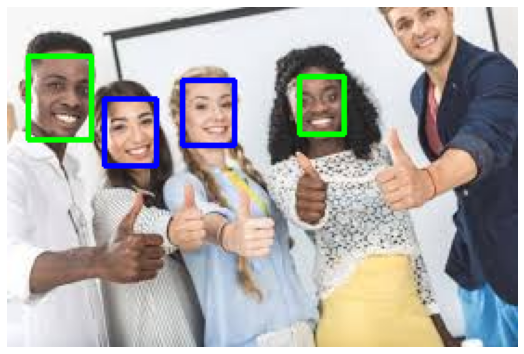

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  10


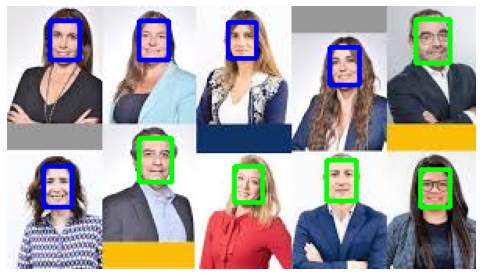

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Number of people:  1


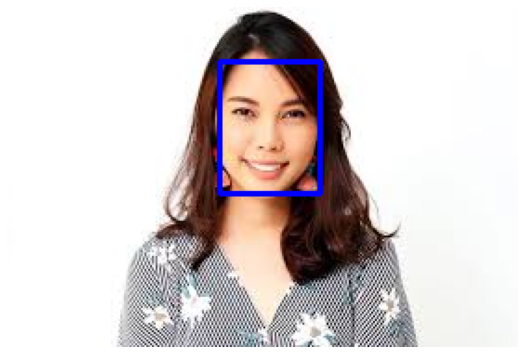

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  3


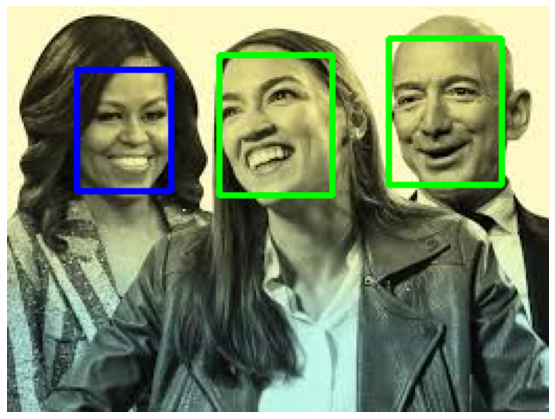

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  2


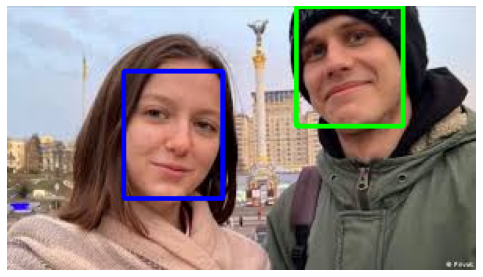

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  2


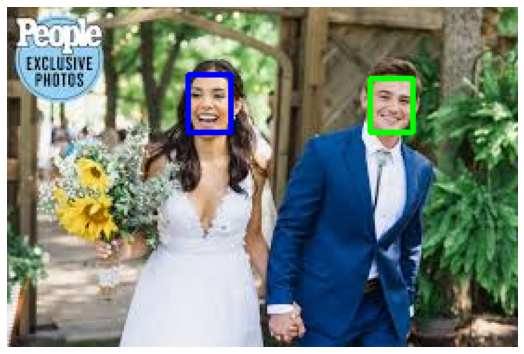

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  6


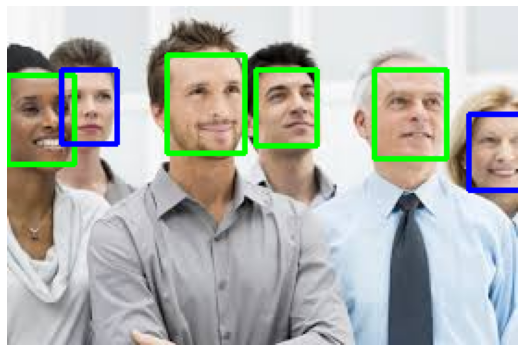

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  2


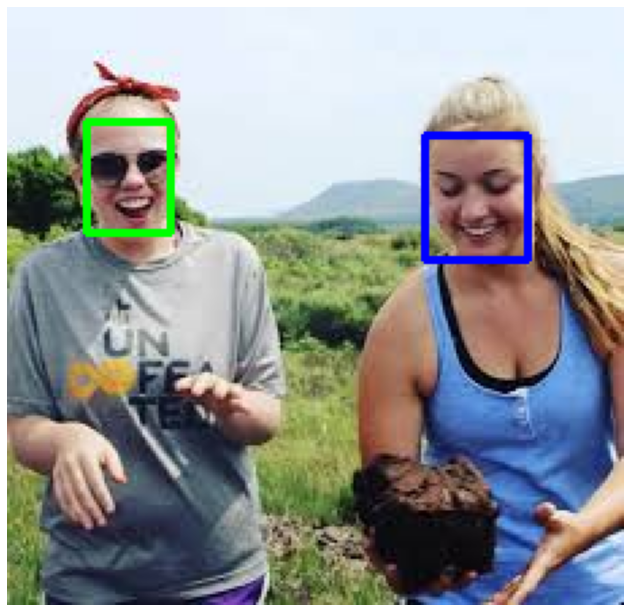

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  2


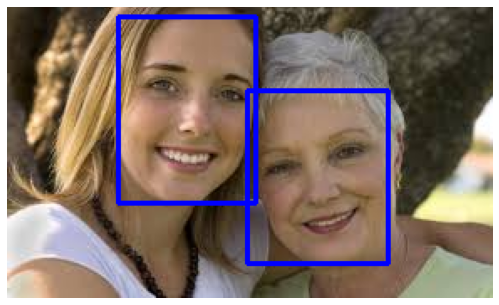

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  4


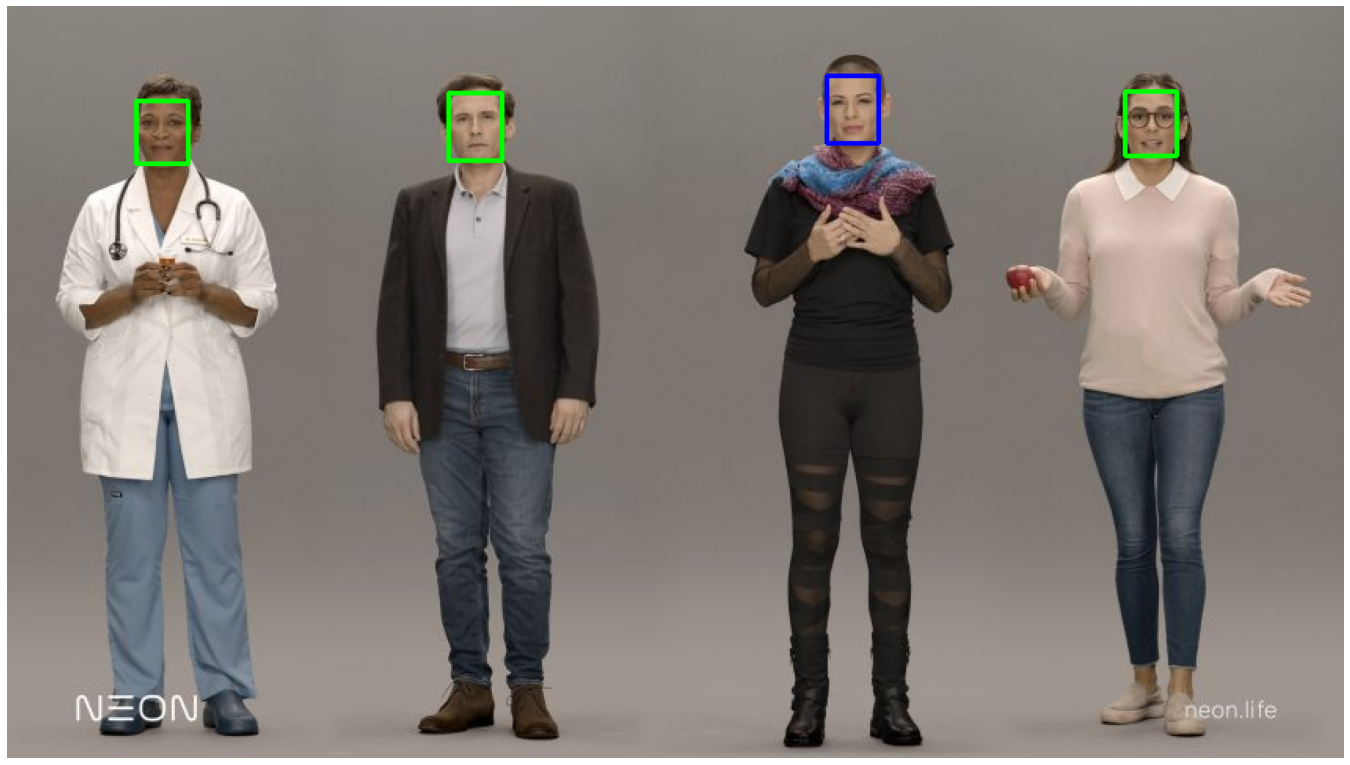

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Number of people:  1


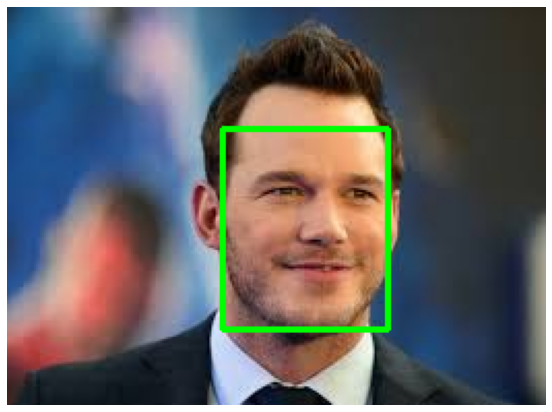

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Number of people:  1


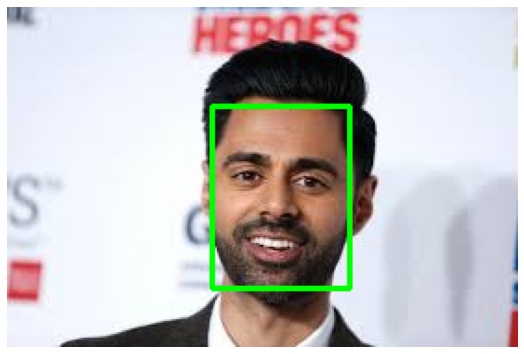

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Number of people:  1


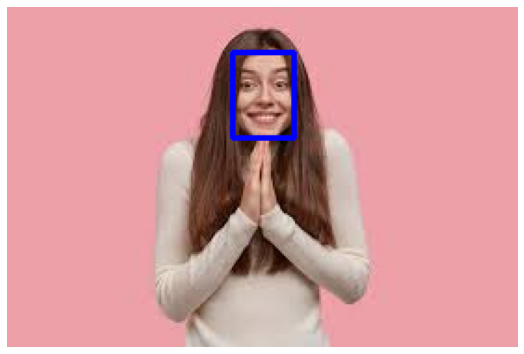

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  4


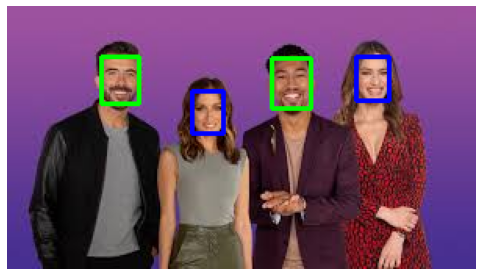

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  2


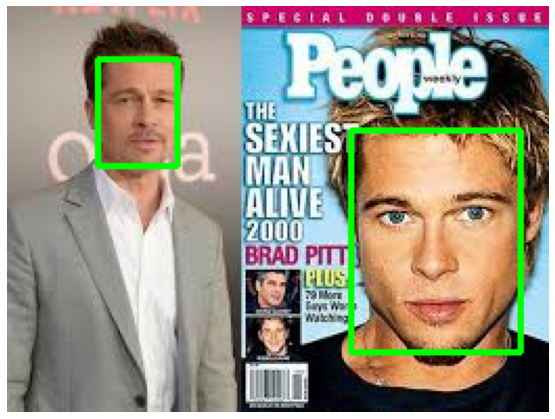

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  3


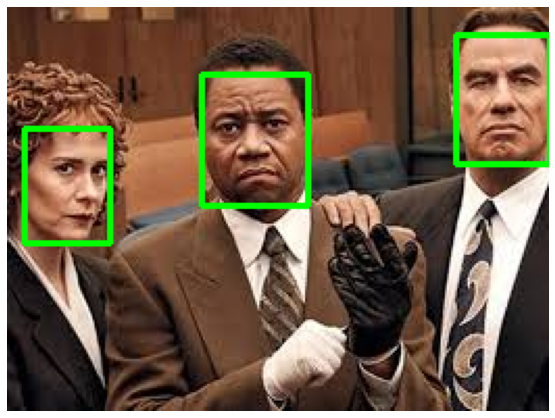

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  3


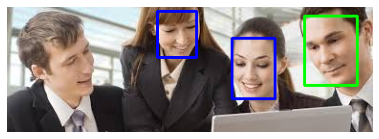

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  2


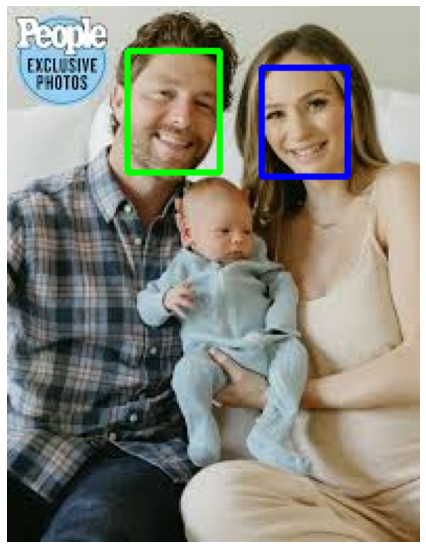

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Number of people:  1


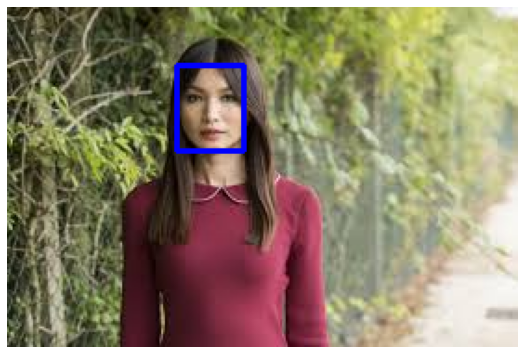

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  2


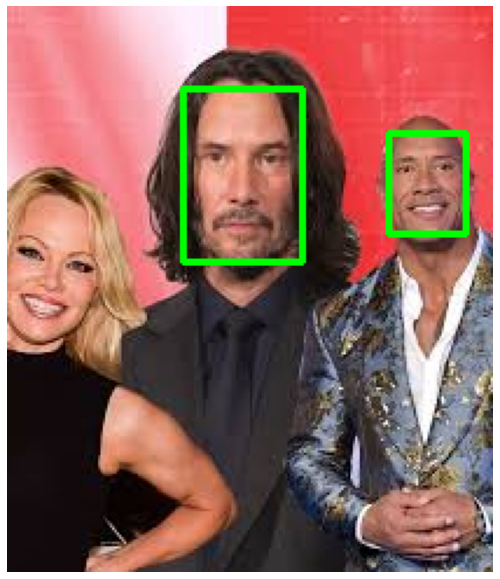

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  2


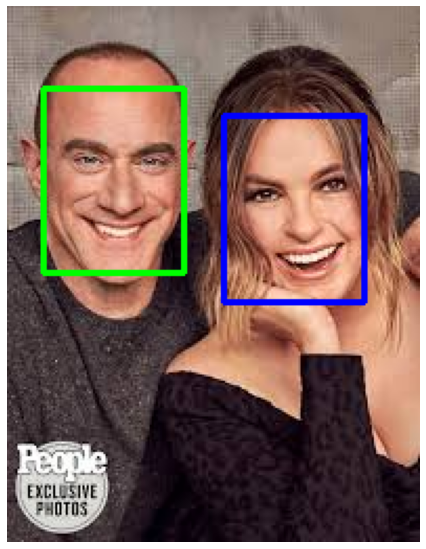

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Number of people:  1


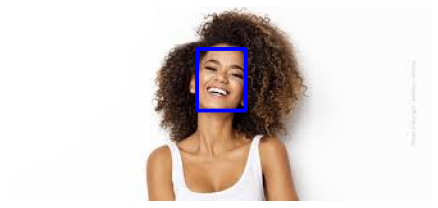

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  6


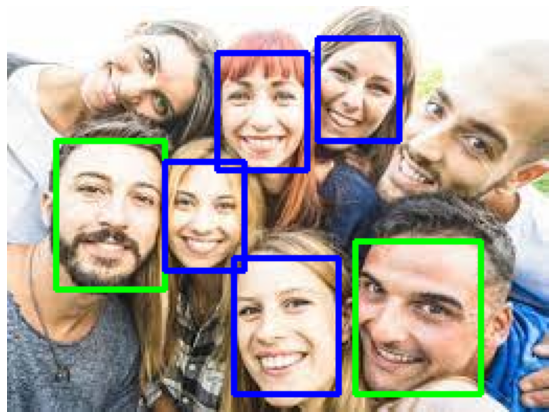

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  2


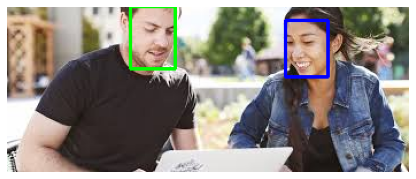

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Number of people:  6


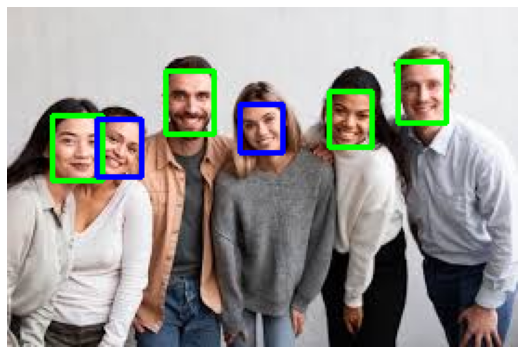

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Number of people:  1


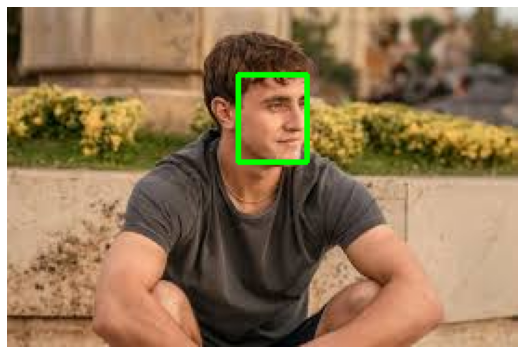

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Number of people:  1


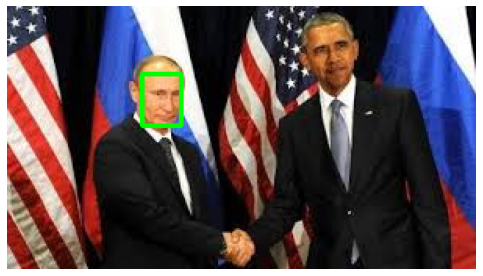

keys:
Blue box = female
green box = male

Found 1 images belonging to 1 classes.
Number of people:  1


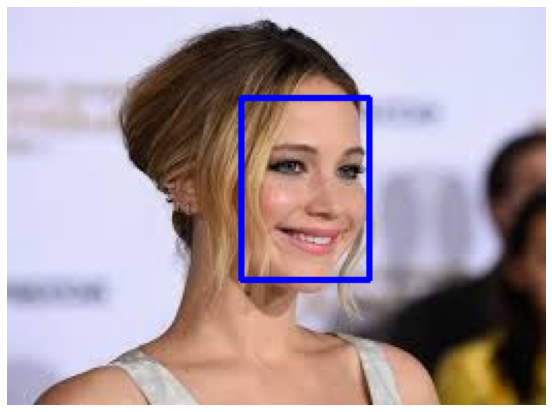

keys:
Blue box = female
green box = male



In [10]:
model = keras.models.load_model('gender_classification_model')
dirc = 'test_images/'
for image in os.listdir(dirc):
    # print(image)
    result(os.path.join(dirc,image))

As can be seen clearly the both models works best if there are 1-3 people in the image. If there are more people in the image the MTCNN works accurately unless the image quality is very low or the face is higly rotated, but our cnn model fails and i think it is because the face image quality becomes poorer